**DESPRE**: În acest notebook: am extras caracteristici (MFDFA+Surfboard) pentru fiecare vocală separat (un fișier csv pentru A, E, I, O, U). Apoi, un model ML a fost antrenat de 3 ori: o dată pentru audio mai scurte de 2 secunde, mai lungi de 2 secunde și audio de toate lungimile.


# **Installs**

In [ ]:
pip install MFDFA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


----Installs for FSM used for Relief feature selection.---------

In [ ]:
!pip install skrebate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install mrmr_selection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install bottleneck

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sklearn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install mifs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement mifs (from versions: none)
ERROR: No matching distribution found for mifs


^^^^----------------------Installs for FSM used for Relief feature selection.----------------------^^^^

Installing surfboard...more info: https://surfboard.readthedocs.io/en/latest/installation.html

In [ ]:
!pip install surfboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numba-0.48.0-1-cp38-cp38-manylinux2014_x86_64.whl (3.6 MB)
  Using cached llvmlite-0.31.0-cp38-cp38-manylinux1_x86_64.whl (20.2 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.36.0
    Uninstalling llvmlite-0.36.0:
      Successfully uninstalled llvmlite-0.36.0
  Attempting uninstall: numba
    Found existing installation: numba 0.53.0
    Uninstalling numba-0.53.0:
      Successfully uninstalled numba-0.53.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyrpde 0.1.3 requires numba>=0.49.1, but you have numba 0.48.0 which is incompatible.


In [ ]:
!pip install numba==0.53.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numba-0.53.0-cp38-cp38-manylinux2014_x86_64.whl (3.4 MB)
  Using cached llvmlite-0.36.0-cp38-cp38-manylinux2010_x86_64.whl (25.3 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.31.0
    Uninstalling llvmlite-0.31.0:
      Successfully uninstalled llvmlite-0.31.0
  Attempting uninstall: numba
    Found existing installation: numba 0.48.0
    Uninstalling numba-0.48.0:
      Successfully uninstalled numba-0.48.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
surfboard 0.2.0 requires numba==0.48.0, but you have numba 0.53.0 which is incompatible.


In [ ]:
!pip install --ignore-installed llvmlite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached llvmlite-0.39.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.53.0 requires llvmlite<0.37,>=0.36.0rc1, but you have llvmlite 0.39.1 which is incompatible.


In [ ]:
!pip install pyrpde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached llvmlite-0.36.0-cp38-cp38-manylinux2010_x86_64.whl (25.3 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1


In [ ]:
!pip install praat-parselmouth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Imports**

In [ ]:
from surfboard.sound import Waveform
from surfboard.feature_extraction import extract_features
import parselmouth
from parselmouth.praat import call
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import sklearn
import pathlib
import csv
import os
import math
from PIL import Image
import warnings
from MFDFA import MFDFA
from MFDFA import fgn
warnings.filterwarnings('ignore')
from scipy.optimize import curve_fit




from sklearn.model_selection import train_test_split

# **Data loading and feature extraction**

> Loaded file names, label names and the waveforms in dictionaries. The dictionary has keys for each vowel, and each key has a list which will have, for example in the case of waveforms, lists containing all the audio samples. Then creating csv file for each vowel.




In [ ]:
main_folder = "/content/drive/MyDrive/Audio Data/Vowels"

In [ ]:
vowels = "A".split()
controls = "Control Patologicas".split()

In [ ]:
file_names = {vowels[0]:[]}
waveforms = {vowels[0]:[]}
sound_librosa = {vowels[0]:[]}
label_names = {vowels[0]:[]}

In [ ]:
for v in vowels:
  for c in controls:
    for filename in os.listdir(f"{main_folder}/{c}/{v}"):
      file_names[v].append(filename)
      label_names[v].append(c)
      sound_librosa[v].append(librosa.load(f"{main_folder}/{c}/{v}/{filename}")[0])
      waveforms[v].append(Waveform(path=os.path.join(f"{main_folder}/{c}/{v}/{filename}")))

### MFDFA coeff

In [ ]:
def objective(x, a, b, c, d, g):
    return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )

In [ ]:
def fit_mdfa(signal):
    t_max = len(signal)
    delta = 1
    time_iter = np.arange(0, t_max, delta)
    lag = np.logspace(0.7, 4, 30).astype(int)

    # Select the power q
    q = 2

    # The order of the polynomial fitting
    order = 1

    # Obtain the (MF)DFA as
    lag, dfa = MFDFA(signal, lag = lag, q = q, order = order)
    dfa[~np.isfinite(dfa)] = 0
    popt, _ = curve_fit(objective, lag, dfa.flatten(), maxfev=100000000)
    a, b, c, d, g = popt
    return a, b, c, d, g

### Continuing

In [ ]:
duration = []
a = []
b = []
c = []
d = []
g = []

In [ ]:
for signal in sound_librosa[vowels[0]]:
  duration.append(librosa.get_duration(y=signal))
  a1, b1, c1, d1, g1 = fit_mdfa(signal)
  a.append(a1)
  b.append(b1)
  c.append(c1)
  d.append(d1)
  g.append(g1)

<ipython-input-273-2ca49bdb75c7>:2: RuntimeWarning: invalid value encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
<ipython-input-273-2ca49bdb75c7>:2: RuntimeWarning: overflow encountered in power
  return ( ( (a-d) / ( (1+( (x/c)** b )) **g) ) + d )
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [ ]:
features = pd.DataFrame({'filename': file_names[vowels[0]],'duration':duration, "a":a,"b":b,"c":c,"d":d,"g":g})

In [ ]:
features.head()

,filename,duration,a,b,c,d,g
0,AVPEPUDEAC0001u1.wav,0.945624,0.001032,2.169425,55.568393,0.330444,1.378344
1,AVPEPUDEAC0001u2.wav,0.713243,0.001873,2.248821,53.709778,0.321121,1.117390
2,AVPEPUDEAC0001u3.wav,1.610431,0.001918,1.870120,5254.418692,0.745454,3849.358639
3,AVPEPUDEAC0003u1.wav,3.942313,0.001005,2.140444,63.683365,0.436536,1.086134
4,AVPEPUDEAC0003u2.wav,5.340816,0.004552,2.416168,52.686015,0.631657,0.853819


In [ ]:
for v in vowels:
  # Note that we only pick components for which statistics are defined (i.e. time series) to make
  # the code neater.
  components_list = [
      'mfcc', 'f0_contour', 'f0_statistics', 'intensity', 'rms',
      'log_energy', 'loudness_slidingwindow', 'ppe', 'jitters', 'shimmers',
      'dfa','formants','hnr','lpc']

  statistics_list = ['mean']

  # Extract dataframe...
  feature_df = extract_features(
      waveforms=waveforms[v], components_list=components_list, statistics_list = statistics_list
  )
  feature_df = feature_df.add_suffix(f'_{v}')
  features = pd.concat([features, feature_df], axis=1, join='inner')


Extracting features...:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/librosa/util/utils.py:2099: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.dtype(np.float): np.complex,
/usr/local/lib/python3.8/dist-packages/librosa/util/utils.py:2099: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.dtype(n

For some odd reason, a column called lpc_U is added containing only NaNs values. We must remove it if that is the case. (Sometimes it would not be there ??) IDK :)

In [ ]:
if 'lpc_U' in features.columns:
  print("Deleted.")
  features = features.drop('lpc_U', axis = 1)

In [ ]:
features.head()

,filename,duration,a,b,c,d,g,mfcc_mean_1_U,mfcc_mean_2_U,mfcc_mean_3_U,...,f1_U,f2_U,f3_U,f4_U,hnr_U,LPC_0_U,LPC_1_U,LPC_2_U,LPC_3_U,LPC_4_U
0,AVPEPUDEAC0001u1.wav,0.945624,0.001032,2.169425,55.568393,0.330444,1.378344,-527.042114,138.996887,63.262894,...,413.608885,855.923600,2691.467349,3799.771303,25.690630,1.0,-1.616006,0.545474,-0.210866,0.286774
1,AVPEPUDEAC0001u2.wav,0.713243,0.001873,2.248821,53.709778,0.321121,1.117390,-527.625916,145.302902,63.812679,...,366.778626,773.168390,2650.082362,3589.815036,23.842138,1.0,-1.539481,0.423439,-0.195197,0.316220
2,AVPEPUDEAC0001u3.wav,1.610431,0.001918,1.870120,5254.418692,0.745454,3849.358639,-491.273834,152.821289,61.418854,...,730.356398,2802.277666,3767.566577,5145.967325,31.139092,1.0,-2.011995,1.356277,-0.654453,0.314099
3,AVPEPUDEAC0003u1.wav,3.942313,0.001005,2.140444,63.683365,0.436536,1.086134,-482.947205,197.650314,68.047279,...,671.522902,2192.993042,3346.745084,5069.993537,16.921561,1.0,-1.642249,0.356673,0.245914,0.042785
4,AVPEPUDEAC0003u2.wav,5.340816,0.004552,2.416168,52.686015,0.631657,0.853819,-451.259766,210.282440,62.471970,...,594.500902,2181.058987,3110.540368,5115.181137,9.182765,1.0,-1.815578,0.586728,0.301841,-0.070649


In [ ]:
features.describe()

,duration,a,b,c,d,g,mfcc_mean_1_U,mfcc_mean_2_U,mfcc_mean_3_U,mfcc_mean_4_U,...,f1_U,f2_U,f3_U,f4_U,hnr_U,LPC_0_U,LPC_1_U,LPC_2_U,LPC_3_U,LPC_4_U
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.0,300.000000,300.000000,300.000000,300.000000
mean,2.475654,0.000332,2.293965,1090.555831,0.558855,312.989159,-562.849365,147.028992,55.737259,48.776840,...,820.027997,2213.383335,3364.068262,4350.549023,24.267637,1.0,-1.853709,1.047989,-0.472911,0.282783
std,2.192602,0.025098,0.578605,4193.655563,3.940482,1071.479274,97.869621,22.897360,22.007282,15.743812,...,510.081558,798.614968,538.785086,537.391857,5.016546,0.0,0.440540,0.920768,0.654287,0.233665
min,0.368254,-0.427768,0.056582,16.763165,0.016885,0.008569,-777.747375,89.834618,-2.206606,-5.490406,...,0.000000,340.917697,835.252970,2588.085080,8.552106,1.0,-2.934366,-1.252146,-2.347799,-0.755542
25%,1.164558,-0.000030,1.933973,42.748481,0.103319,0.891731,-635.427734,131.249054,40.443949,39.970139,...,555.197783,2047.361451,2982.396001,3907.612482,21.546299,1.0,-2.137511,0.327115,-0.936460,0.144403
50%,1.792381,0.000923,2.245035,56.057441,0.261364,1.227470,-555.443085,144.615837,57.714029,48.365957,...,701.596544,2510.263888,3349.601574,4363.799198,24.626921,1.0,-1.888713,1.019902,-0.416221,0.313314
75%,2.874739,0.002792,2.529695,114.095735,0.433196,2.761704,-498.312744,163.699776,70.967701,58.286515,...,805.371438,2736.175942,3743.208708,4741.863145,27.503237,1.0,-1.548434,1.667427,0.033682,0.434974
max,15.105941,0.027231,5.976106,38040.188455,68.305613,5865.184591,-273.180115,210.282440,106.798698,98.268127,...,2503.577008,4172.477511,4582.823503,5810.900016,35.495991,1.0,-0.614170,3.434869,1.702439,0.855708


Let's see how many NaNs we have in each column.

In [ ]:
columns_list = list(features)
columns_list = columns_list[1:]
print(columns_list)
for c in columns_list:
  print(features[c].isna().sum(), end = ' ')

['duration', 'a', 'b', 'c', 'd', 'g', 'mfcc_mean_1_U', 'mfcc_mean_2_U', 'mfcc_mean_3_U', 'mfcc_mean_4_U', 'mfcc_mean_5_U', 'mfcc_mean_6_U', 'mfcc_mean_7_U', 'mfcc_mean_8_U', 'mfcc_mean_9_U', 'mfcc_mean_10_U', 'mfcc_mean_11_U', 'mfcc_mean_12_U', 'mfcc_mean_13_U', 'f0_contour_mean_U', 'f0_mean_U', 'f0_std_U', 'intensity_mean_U', 'rms_mean_U', 'log_energy_U', 'loudness_slidingwindow_mean_U', 'ppe_U', 'localJitter_U', 'localabsoluteJitter_U', 'rapJitter_U', 'ppq5Jitter_U', 'ddpJitter_U', 'localShimmer_U', 'localdbShimmer_U', 'apq3Shimmer_U', 'apq5Shimmer_U', 'apq11Shimmer_U', 'dfa_U', 'f1_U', 'f2_U', 'f3_U', 'f4_U', 'hnr_U', 'LPC_0_U', 'LPC_1_U', 'LPC_2_U', 'LPC_3_U', 'LPC_4_U']
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 21 0 0 0 1 1 1 0 0 1 1 5 0 0 0 0 0 0 0 0 0 0 0 

Eliminating NaNs by replacing with mean of columns.

In [ ]:
for c in columns_list:
  features[c].fillna((features[c].mean()), inplace=True)


In [ ]:
for c in columns_list:
  print(features[c].isna().sum(), end = ' ')

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
print(features.columns)
labels = []
for e in label_names[vowels[0]]:
  if e == "Control":
    labels.append(0)
  else:
    labels.append(1)
print(labels)
labels_df = pd.DataFrame({'label': labels})
print(labels_df.head())

Index(['filename', 'duration', 'a', 'b', 'c', 'd', 'g', 'mfcc_mean_1_U',
       'mfcc_mean_2_U', 'mfcc_mean_3_U', 'mfcc_mean_4_U', 'mfcc_mean_5_U',
       'mfcc_mean_6_U', 'mfcc_mean_7_U', 'mfcc_mean_8_U', 'mfcc_mean_9_U',
       'mfcc_mean_10_U', 'mfcc_mean_11_U', 'mfcc_mean_12_U', 'mfcc_mean_13_U',
       'f0_contour_mean_U', 'f0_mean_U', 'f0_std_U', 'intensity_mean_U',
       'rms_mean_U', 'log_energy_U', 'loudness_slidingwindow_mean_U', 'ppe_U',
       'localJitter_U', 'localabsoluteJitter_U', 'rapJitter_U', 'ppq5Jitter_U',
       'ddpJitter_U', 'localShimmer_U', 'localdbShimmer_U', 'apq3Shimmer_U',
       'apq5Shimmer_U', 'apq11Shimmer_U', 'dfa_U', 'f1_U', 'f2_U', 'f3_U',
       'f4_U', 'hnr_U', 'LPC_0_U', 'LPC_1_U', 'LPC_2_U', 'LPC_3_U', 'LPC_4_U'],
      dtype='object')
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
features_with_labels = pd.concat([features, labels_df], axis=1, join='inner')


In [ ]:
features_with_labels

,filename,duration,a,b,c,d,g,mfcc_mean_1_U,mfcc_mean_2_U,mfcc_mean_3_U,...,f2_U,f3_U,f4_U,hnr_U,LPC_0_U,LPC_1_U,LPC_2_U,LPC_3_U,LPC_4_U,label
0,AVPEPUDEAC0001u1.wav,0.945624,0.001032,2.169425,55.568393,0.330444,1.378344,-527.042114,138.996887,63.262894,...,855.923600,2691.467349,3799.771303,25.690630,1.0,-1.616006,0.545474,-0.210866,0.286774,0
1,AVPEPUDEAC0001u2.wav,0.713243,0.001873,2.248821,53.709778,0.321121,1.117390,-527.625916,145.302902,63.812679,...,773.168390,2650.082362,3589.815036,23.842138,1.0,-1.539481,0.423439,-0.195197,0.316220,0
2,AVPEPUDEAC0001u3.wav,1.610431,0.001918,1.870120,5254.418692,0.745454,3849.358639,-491.273834,152.821289,61.418854,...,2802.277666,3767.566577,5145.967325,31.139092,1.0,-2.011995,1.356277,-0.654453,0.314099,0
3,AVPEPUDEAC0003u1.wav,3.942313,0.001005,2.140444,63.683365,0.436536,1.086134,-482.947205,197.650314,68.047279,...,2192.993042,3346.745084,5069.993537,16.921561,1.0,-1.642249,0.356673,0.245914,0.042785,0
4,AVPEPUDEAC0003u2.wav,5.340816,0.004552,2.416168,52.686015,0.631657,0.853819,-451.259766,210.282440,62.471970,...,2181.058987,3110.540368,5115.181137,9.182765,1.0,-1.815578,0.586728,0.301841,-0.070649,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,AVPEPUDEA0030u3.wav,6.863764,0.009714,2.750496,37.525238,0.551034,1.102326,-385.816101,165.458923,23.407669,...,1145.286263,2396.921967,3647.040404,23.367221,1.0,-1.548151,0.205678,0.303067,0.045628,1
296,AVPEPUDEA0030u1.wav,3.864308,0.009550,2.659003,42.740754,0.583846,1.436370,-381.855286,164.596481,25.796793,...,2402.270727,3113.141610,3642.022565,24.069607,1.0,-1.516897,0.181983,0.254268,0.086902,1
297,AVPEPUDEA0031u1.wav,7.653197,0.000456,2.194268,58.061832,0.116700,1.033864,-591.477417,138.089401,43.482773,...,709.266717,2661.779913,3953.369773,24.661340,1.0,-1.788854,0.754325,-0.037684,0.075670,1
298,AVPEPUDEA0031u2.wav,4.306576,0.001121,2.667811,36.746781,0.087164,0.645740,-592.837952,135.703751,41.050583,...,2737.853888,4076.692023,4955.042402,23.179543,1.0,-1.803403,0.792449,-0.073629,0.089061,1


In [ ]:
with open(f'/content/drive/MyDrive/Parkinson CSV files/Does audio length influence anything?/vowel_{vowels[0]}_features.csv', 'w') as csv_file:
    features_with_labels.to_csv(path_or_buf=csv_file)
#_length_conditioned

# TabPFN

## Install and imports

**In order to get the fastest predictions you need to enable GPUs for the notebook:**
* Navigate to Edit→Notebook Settings
* select GPU from the Hardware Accelerator drop-down
(https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=oM_8ELnJq_wd)

In [ ]:
!pip install tabpfn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import os
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics


from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from tabpfn.scripts.decision_boundary import DecisionBoundaryDisplay


## Features

In [ ]:
main_folder = "/content/drive/MyDrive/Audio Data/Vowels"

vowels = "U".split()
controls = "Control Patologicas".split()

In [ ]:
# Read in data and display first 5 rows
features = pd.read_csv(f'/content/drive/MyDrive/Parkinson CSV files/Does audio length influence anything?/vowel_{vowels[0]}_features.csv', index_col = 0)
features.head(5)

,filename,duration,a,b,c,d,g,mfcc_mean_1_U,mfcc_mean_2_U,mfcc_mean_3_U,...,f2_U,f3_U,f4_U,hnr_U,LPC_0_U,LPC_1_U,LPC_2_U,LPC_3_U,LPC_4_U,label
0,AVPEPUDEAC0001u1.wav,0.945624,0.001032,2.169425,55.568393,0.330444,1.378344,-527.04210,138.99689,63.262894,...,855.923600,2691.467349,3799.771303,25.690630,1.0,-1.616006,0.545474,-0.210866,0.286774,0
1,AVPEPUDEAC0001u2.wav,0.713243,0.001873,2.248821,53.709778,0.321121,1.117390,-527.62590,145.30290,63.812680,...,773.168390,2650.082362,3589.815036,23.842138,1.0,-1.539481,0.423439,-0.195197,0.316220,0
2,AVPEPUDEAC0001u3.wav,1.610431,0.001918,1.870120,5254.418692,0.745454,3849.358639,-491.27383,152.82129,61.418854,...,2802.277666,3767.566577,5145.967325,31.139092,1.0,-2.011995,1.356277,-0.654453,0.314099,0
3,AVPEPUDEAC0003u1.wav,3.942313,0.001005,2.140444,63.683365,0.436536,1.086134,-482.94720,197.65031,68.047280,...,2192.993042,3346.745084,5069.993537,16.921561,1.0,-1.642249,0.356673,0.245914,0.042785,0
4,AVPEPUDEAC0003u2.wav,5.340816,0.004552,2.416168,52.686015,0.631657,0.853819,-451.25977,210.28244,62.471970,...,2181.058987,3110.540368,5115.181137,9.182765,1.0,-1.815578,0.586728,0.301841,-0.070649,0


In [ ]:
features.shape

(300, 50)

In [ ]:
features.describe()


,duration,a,b,c,d,g,mfcc_mean_1_U,mfcc_mean_2_U,mfcc_mean_3_U,mfcc_mean_4_U,...,f2_U,f3_U,f4_U,hnr_U,LPC_0_U,LPC_1_U,LPC_2_U,LPC_3_U,LPC_4_U,label
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.0,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2.475654,0.000332,2.293965,1090.555831,0.558855,312.989159,-562.848974,147.029004,55.737252,48.776842,...,2213.383335,3364.068262,4350.549023,24.267637,1.0,-1.853710,1.047989,-0.472911,0.282784,0.500000
std,2.192602,0.025098,0.578605,4193.655563,3.940482,1071.479274,97.869629,22.897356,22.007277,15.743813,...,798.614968,538.785086,537.391857,5.016546,0.0,0.440540,0.920768,0.654287,0.233665,0.500835
min,0.368254,-0.427768,0.056582,16.763165,0.016885,0.008569,-777.747400,89.834620,-2.206606,-5.490406,...,340.917697,835.252970,2588.085080,8.552106,1.0,-2.934366,-1.252146,-2.347799,-0.755542,0.000000
25%,1.164558,-0.000030,1.933973,42.748481,0.103319,0.891731,-635.427725,131.249057,40.443948,39.970139,...,2047.361451,2982.396001,3907.612482,21.546299,1.0,-2.137511,0.327115,-0.936460,0.144403,0.000000
50%,1.792381,0.000923,2.245035,56.057441,0.261364,1.227470,-555.443085,144.615835,57.714030,48.365958,...,2510.263888,3349.601574,4363.799198,24.626921,1.0,-1.888713,1.019902,-0.416222,0.313314,0.500000
75%,2.874739,0.002792,2.529695,114.095735,0.433196,2.761704,-498.312745,163.699777,70.967704,58.286515,...,2736.175942,3743.208708,4741.863145,27.503237,1.0,-1.548434,1.667427,0.033682,0.434974,1.000000
max,15.105941,0.027231,5.976106,38040.188455,68.305613,5865.184591,-273.180100,210.282440,106.798700,98.268130,...,4172.477511,4582.823503,5810.900016,35.495991,1.0,-0.614170,3.434869,1.702439,0.855708,1.000000


In [ ]:
features['label']

0      0
1      0
2      0
3      0
4      0
      ..
295    1
296    1
297    1
298    1
299    1
Name: label, Length: 300, dtype: int64

In [ ]:
features.groupby('label').count()

,filename,duration,a,b,c,d,g,mfcc_mean_1_U,mfcc_mean_2_U,mfcc_mean_3_U,...,f1_U,f2_U,f3_U,f4_U,hnr_U,LPC_0_U,LPC_1_U,LPC_2_U,LPC_3_U,LPC_4_U
label,,,,,,,,,,,,,,,,,,,,,
0,150,150,150,150,150,150,150,150,150,150,...,150,150,150,150,150,150,150,150,150,150
1,150,150,150,150,150,150,150,150,150,150,...,150,150,150,150,150,150,150,150,150,150


In [ ]:
# < 2 SECONDS
features_less_conditioned = features
features_less_conditioned = features_less_conditioned[features_less_conditioned.duration < 2]
features_less_conditioned.groupby('label').count()


,filename,duration,a,b,c,d,g,mfcc_mean_1_U,mfcc_mean_2_U,mfcc_mean_3_U,...,f1_U,f2_U,f3_U,f4_U,hnr_U,LPC_0_U,LPC_1_U,LPC_2_U,LPC_3_U,LPC_4_U
label,,,,,,,,,,,,,,,,,,,,,
0,95,95,95,95,95,95,95,95,95,95,...,95,95,95,95,95,95,95,95,95,95
1,76,76,76,76,76,76,76,76,76,76,...,76,76,76,76,76,76,76,76,76,76


In [ ]:
labels_less_conditioned = np.array(features_less_conditioned['label'])
# Remove the labels from the features
features_less_conditioned = features_less_conditioned.drop(['filename','duration', 'label'], axis = 1)

#features_less_conditioned= features_less_conditioned[['a','b','c','d','g']]

# Saving feature names for later use
feature_list_less_conditioned = list(features_less_conditioned.columns)

# Convert to numpy array
features_less_conditioned = np.array(features_less_conditioned)

In [ ]:
# >=2 SECONDS
features_more_conditioned = features
features_more_conditioned = features_more_conditioned[(features_more_conditioned.duration >= 2) & (features_more_conditioned.duration <= 4)]
features_more_conditioned.groupby('label').count()


,filename,duration,a,b,c,d,g,mfcc_mean_1_U,mfcc_mean_2_U,mfcc_mean_3_U,...,f1_U,f2_U,f3_U,f4_U,hnr_U,LPC_0_U,LPC_1_U,LPC_2_U,LPC_3_U,LPC_4_U
label,,,,,,,,,,,,,,,,,,,,,
0,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
1,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50


In [ ]:
labels_more_conditioned = np.array(features_more_conditioned['label'])
# Remove the labels from the features
features_more_conditioned = features_more_conditioned.drop(['filename','duration', 'label'], axis = 1)

#features_more_conditioned= features_more_conditioned[['a','b','c','d','g']]

# Saving feature names for later use
feature_list_more_conditioned = list(features_more_conditioned.columns)

# Convert to numpy array
features_more_conditioned = np.array(features_more_conditioned)

In [ ]:
labels = np.array(features['label'])
# Remove the labels from the features
features= features.drop(['filename','duration', 'label'], axis = 1)

#features= features[['a','b','c','d','g']]


# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

## Model

#### No condition

In [ ]:
X = features
y = labels

In [ ]:
skf=StratifiedShuffleSplit(n_splits=2,test_size=0.33)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [120 264 204 122 256  25   2  59 118 201 110  82  22  87  79 272 225 185
 258  11   6 208  76 263 144  52 283 119 169 285 242 223 224  44 100 150
  50  62 202 179 162  81 245 205 140  83 254 172 159 241 265  47  49  40
  34  13 231 181  72 195 116  45 109 270  15 206 209 198 107 173 218 292
  98  27  71 219 128 207 139 227 293 134  55 235  61  70 160 152 192 233
 248 145  38 267 252  51 230  42 275 143  48  65   4 175  97 127 168 266
 288 199  60  78 269  35 106 154  80   3 153 278 290 259 286 273 190  95
  58  16 115 268  30 237 210  66 166  31 250  19 232  20 135 280 226 113
 164  63 249  12 257 260 170 240 171 136   8 102 217 111 105 271 196 121
 238 281 131 203 178   7 126 146   0  68 279 297  69 114  96 296 141 299
 197  10  57   5  85 108 277  14  75 142 161  39 298  33 165 243 229 186
 117 211 103] TEST: [287 200 274  91 239 176 101  64 216   9  37  18  92 112 262 184 251 157
  56 155 189 244  99 149 222  90 104 188 180 220  67  28 124 284 148  24
 215 177 213  89 193 253

In [ ]:
# N_ensemble_configurations defines how many estimators are averaged, it is bounded by #features * #classes
# more ensemble members are slower, but more accurate
classifier = TabPFNClassifier(device='cuda', N_ensemble_configurations=4)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [ ]:
start = time.time()
classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)
y_pred_proba = classifier.predict_proba(X_test)[::,1]
print('Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval))

Prediction time:  0.5168874263763428 Accuracy 0.8585858585858586


In [ ]:
# print(file, type(file))
out_table = pd.DataFrame(X_test.copy().astype(str))
out_table['prediction'] = [f"{y_e} (p={p_e:.2f})" for y_e, p_e in zip(y_eval, p_eval)]
out_table

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,prediction
0,0.0013189841995445,2.2641221638099016,178.84354833652395,0.1998457015800279,6.257345508850165,-657.1818,127.36045,78.07962,44.87321,16.268362,...,2812.630179938383,4038.895264467295,5227.509132181877,28.06820904673212,1.0,-1.1423903,-0.24564362,-0.057315767,0.4477139,1 (p=0.62)
1,0.0010323545314115,2.169424872494098,55.568392632602944,0.3304438738345613,1.378344439465265,-527.0421,138.99689,63.262894,45.264217,1.0161366,...,855.923599593989,2691.4673491232497,3799.771302651279,25.69062954071532,1.0,-1.6160061,0.5454736,-0.21086594,0.28677386,1 (p=0.59)
2,-0.0002009102747613,1.7584913194214584,85.4104885295853,0.033989927615591,1.030866584300153,-745.7875,140.84145,78.148125,52.968254,33.198254,...,2671.147090173822,3694.045875546473,4595.583641082504,16.074782959090463,1.0,-1.0753821,-0.4103,0.11099994,0.37922227,0 (p=0.84)
3,0.000260881037128,2.255365852992604,56.96345355862862,0.0812864963702793,0.8274270410814941,-697.861,162.45546,86.01172,69.542625,32.498444,...,2391.515446805972,3485.9584536093266,4458.116007927544,23.166132920080354,1.0,-1.406703,0.121332124,0.0026830137,0.28624582,0 (p=0.99)
4,-0.0048502831961261,1.7034013046577776,6011.737314065043,0.7198856454409519,3336.0109852611617,-397.24002,136.11697,12.636607,12.061316,-43.053253,...,2875.98559905019,3883.96697502806,5032.618882248407,26.506995210139625,1.0,-2.3610322,2.3704848,-1.6173033,0.61452717,0 (p=0.67)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.0001501119566073,2.1374861115882133,42.92716386236312,0.0632386626257857,1.033155689258234,-645.76245,171.16957,50.940765,62.27537,14.144095,...,2564.9090446334308,2595.617662690565,4528.630650569131,22.131989666982,1.0,-2.0108685,1.0245124,0.01686889,-0.025989605,0 (p=0.97)
95,-7.110381701614995e-05,1.963759049568878,57.05485139524237,0.0485055266115858,1.2035043351129626,-717.6516,147.57953,60.694668,45.445858,19.373518,...,2169.7161288247685,3621.55115459082,4184.940205525845,21.765946177012545,1.0,-1.5520915,0.118491136,0.45103437,-0.011935422,0 (p=0.92)
96,0.0097137782312078,2.750495850981083,37.52523775024937,0.5510337097742756,1.1023256833601764,-385.8161,165.45892,23.40767,-4.79815,6.5465317,...,1145.286262695979,2396.9219666935724,3647.040404039552,23.3672211679808,1.0,-1.5481505,0.20567815,0.30306655,0.045628466,1 (p=0.90)
97,0.0002191504605153,2.310135466063907,48.76310143908046,0.044670764578676,1.0121888896833502,-735.1891,136.85197,59.901817,43.02389,20.075695,...,765.7854332276388,2854.808124091309,3826.510224826711,33.191284899176736,1.0,-0.61417,-1.252146,0.36513132,0.5090991,0 (p=0.98)


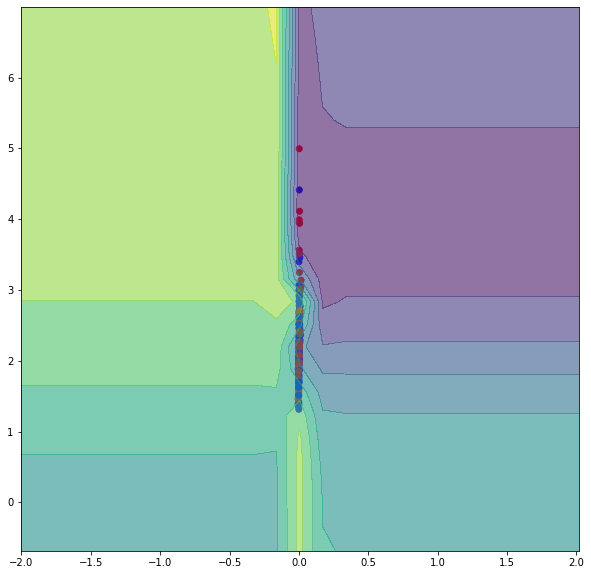

In [ ]:
# PLOTTING
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# Plot the training points
vfunc = np.vectorize(lambda x : np.where(classifier.classes_ == x)[0])
y_train_index = vfunc(y_train)
y_train_index = y_train_index == 0

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train_index, cmap=cm_bright)

classifier.fit(X_train[:, 0:2], y_train_index)

DecisionBoundaryDisplay.from_estimator(
    classifier, X_train[:, 0:2], alpha=0.6, ax=ax, eps=2.0, grid_resolution=25, response_method="predict_proba"
)

#### Conditioned < 2 seconds

In [ ]:
X = features_less_conditioned
y = labels_less_conditioned

In [ ]:
skf=StratifiedShuffleSplit(n_splits=2,test_size=0.33)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [148 101 139 105  49  75 113   4   8  30   5  39 151 146 125  41  24 144
 129  11 135  45 130  72  50  89  31  76 111  90  42 102 134  86  44  21
  27   7  79  20  78  13  82 131 149 162  87  96  85  68 155  62  25   1
  98  47   9 157  93  32 110   2 108  92 156 167 150  70 161 147 127 104
  17 103 143  80  58 163  84 160 165 158  67  60 138  51 154 116  22  35
 112 118  43 166  73 109  55  61 121  28  38  48 120  29  15 115  88 168
 145 133  54  64 100  10] TEST: [169  77  52 137 128  83  63 170  33 153  91  18  34  56  97  53  36  40
  16 164  71  14   6 140  46  12  74 152  26  94 136  95  19 141   0 159
 117  99 123  37 142 122  23   3 106 119  57  65 126  81 124 114  59 107
  69  66 132]
TRAIN: [  3 112  85  98 167 131  94 158 136 125  82 114  15  11  32 152 123  17
 113  75  49  60 155  64 159 148  73  69  12 132 153 124 141   5 128  50
 150  80  48 166 154  16  71  10 156 149  86  91 127 107 104   9  79 137
   6 146  68 108  23  88 143  76  67  61  25  83 105   7  47  21

In [ ]:
# N_ensemble_configurations defines how many estimators are averaged, it is bounded by #features * #classes
# more ensemble members are slower, but more accurate
classifier = TabPFNClassifier(device='cuda', N_ensemble_configurations=4)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [ ]:
start = time.time()
classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)
y_pred_proba = classifier.predict_proba(X_test)[::,1]
print('Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval))

Prediction time:  0.4569430351257324 Accuracy 0.8245614035087719


In [ ]:
# print(file, type(file))
out_table = pd.DataFrame(X_test.copy().astype(str))
out_table['prediction'] = [f"{y_e} (p={p_e:.2f})" for y_e, p_e in zip(y_eval, p_eval)]
out_table

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,prediction
0,-0.0008830368377781,1.984464177942033,85.43750390689969,0.324437889632763,1.7582924282573604,-573.4677,122.81375,75.074455,73.70836,9.758275,...,2677.1964366743987,3385.5912833434827,5104.086061516723,26.648208561030724,1.0,-1.9592425,1.4512949,-0.9757428,0.48665857,1 (p=0.55)
1,0.0061302761962916,2.7728564839518817,37.56536141128485,0.4099894336356918,0.9146894947628508,-527.68555,137.33302,49.423214,53.204685,13.625165,...,2843.0232343293164,3286.1841687160654,3847.274281521547,32.584515066422135,1.0,-2.1360614,1.8081992,-1.1891705,0.5214674,0 (p=0.92)
2,0.0053009386501011,2.407841279233148,58.18550583056926,0.4844998831607096,1.206205578607236,-445.09048,167.64662,15.559459,58.585407,24.195219,...,2679.6482152422564,3986.5495621662526,4895.824344183221,25.975517132931948,1.0,-2.4615123,2.2634354,-1.0763314,0.27673882,1 (p=0.64)
3,0.0031881988170547,2.409390924895596,52.64309961583152,0.2936987037069754,0.9354892683176104,-508.03934,163.69394,35.47243,64.73549,28.74316,...,2902.249689101682,4135.201582991499,5086.665824308434,22.025995746858914,1.0,-2.0164027,1.2092859,-0.31731102,0.12744501,1 (p=0.94)
4,0.002915495632269,2.410593892972731,46.32642829909816,0.3181575960960759,0.6870536787899226,-532.8912,181.35521,29.084663,40.22733,41.080906,...,2834.635542230795,3771.3056991190074,4617.439411222076,21.26452353484418,1.0,-2.109428,1.1356525,0.09176563,-0.11581329,1 (p=0.96)
5,0.0010323545314115,2.169424872494098,55.568392632602944,0.3304438738345613,1.378344439465265,-527.0421,138.99689,63.262894,45.264217,1.0161366,...,855.923599593989,2691.4673491232497,3799.771302651279,25.69062954071532,1.0,-1.6160061,0.5454736,-0.21086594,0.28677386,0 (p=0.93)
6,0.0060040345209069,2.96515218722763,40.82352666480858,0.372138791603372,0.7593210986162374,-523.47284,167.09898,89.51256,61.120377,14.540589,...,2156.883857306608,3416.1981596762903,5048.463752339808,20.57552350695461,1.0,-1.4477273,0.19311412,-0.019907564,0.27862665,1 (p=0.82)
7,0.0013189841995445,2.2641221638099016,178.84354833652395,0.1998457015800279,6.257345508850165,-657.1818,127.36045,78.07962,44.87321,16.268362,...,2812.630179938383,4038.895264467295,5227.509132181877,28.06820904673212,1.0,-1.1423903,-0.24564362,-0.057315767,0.4477139,1 (p=0.68)
8,0.0016689406576697,2.5549937215742604,36.479395399389325,0.1549294792734078,0.8478612562663237,-589.7415,138.39688,52.633953,43.76761,6.5297613,...,2764.448808322428,3269.0136880517225,4134.518368214502,20.112233275292997,1.0,-1.8433219,1.3054725,-1.0496725,0.5940759,1 (p=0.67)
9,0.0124631966093163,3.049083357015625,33.909164449877046,0.7452077132592062,0.5344690694390297,-466.16772,151.93222,51.59963,47.595455,2.4421825,...,2286.0341283598937,3728.0857545696585,4555.643475644798,13.338254729757317,1.0,-2.750086,3.026643,-1.7867875,0.51232797,1 (p=0.96)


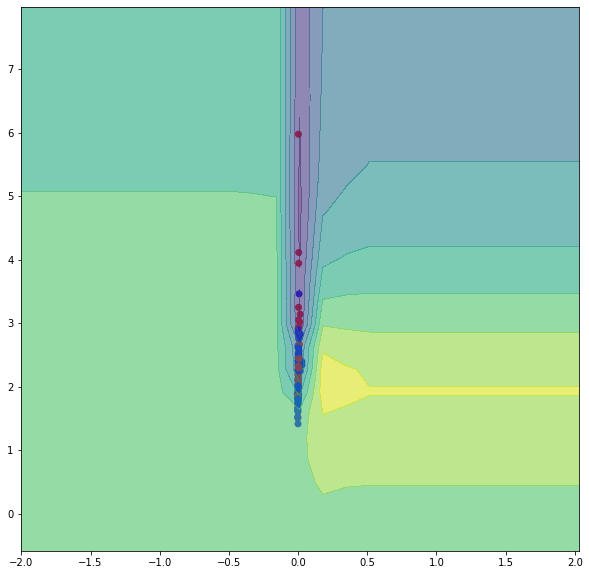

In [ ]:
# PLOTTING
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# Plot the training points
vfunc = np.vectorize(lambda x : np.where(classifier.classes_ == x)[0])
y_train_index = vfunc(y_train)
y_train_index = y_train_index == 0

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train_index, cmap=cm_bright)

classifier.fit(X_train[:, 0:2], y_train_index)

DecisionBoundaryDisplay.from_estimator(
    classifier, X_train[:, 0:2], alpha=0.6, ax=ax, eps=2.0, grid_resolution=25, response_method="predict_proba"
)

#### Conditioned >= 2 seconds

In [ ]:
X = features_more_conditioned
y = labels_more_conditioned

In [ ]:
skf=StratifiedShuffleSplit(n_splits=2,test_size=0.33)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [35 15 56 37 60 19 49 58 50  6 18 80 69  4 72 68 38 63 62 30 16 48 52 40
 75 45 59  8  2 46 34 43  7 41 77 83  9 71 14 25 10 78 51 70 57 53 22  3
 13 29  0  5 67 66 20 31] TEST: [28 44 61 24 73 33 76 26 84 39 21 11 17 47 23 64 74 27 55 42 36 82 79  1
 54 12 81 65 32]
TRAIN: [ 9 57 50 78  8 29 27 38  1 12 41 71 59 52 30 76 69 68 34 10 16 77 70 73
 51 15 74 58  3 24 46 48 11 81 54 53  4 66  0 17 13 45 28 40 61  5 32  2
 65 64 63 43 35 23 67 60] TEST: [39 22 62 18  6 19 26 44 21 75 49  7 80 42 37 55 82 31 36 79 25 72 56 84
 14 33 83 20 47]


In [ ]:
# N_ensemble_configurations defines how many estimators are averaged, it is bounded by #features * #classes
# more ensemble members are slower, but more accurate
classifier = TabPFNClassifier(device='cuda', N_ensemble_configurations=4)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [ ]:
start = time.time()
classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)
y_pred_proba = classifier.predict_proba(X_test)[::,1]
print('Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval))

Prediction time:  0.4662439823150635 Accuracy 0.7586206896551724


In [ ]:
# print(file, type(file))
out_table = pd.DataFrame(X_test.copy().astype(str))
out_table['prediction'] = [f"{y_e} (p={p_e:.2f})" for y_e, p_e in zip(y_eval, p_eval)]
out_table

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,prediction
0,0.0050771160240716,2.588235819527047,41.157812793230455,0.4106632419675943,1.0344455406732096,-507.81708,130.76581,61.965397,63.741085,21.50411,...,2983.57951999802,3497.9447316763626,3950.819176510951,24.634673251962973,1.0,-2.100471,1.492827,-0.6354841,0.24709168,1 (p=0.94)
1,0.0012454344368018,2.455470042516988,49.48983008425295,0.1293141328499337,1.2491153026766135,-646.799,139.67403,69.69277,59.318996,20.95746,...,2659.205378372922,3515.4674705863163,4557.082728374861,25.931274916786244,1.0,-1.854905,0.7501028,0.0798139,0.028315919,1 (p=0.56)
2,0.00118757261162,2.218225134386001,192.47238403081155,0.202037500002279,20.63768706013925,-557.6831,137.4204,32.94637,4.6905327,-1.1806364,...,2184.51190293001,3092.89103592568,4176.709753536202,25.325514787438568,1.0,-1.6361017,0.76857966,-0.5897508,0.46194234,0 (p=0.66)
3,-0.0048502831961261,1.7034013046577776,6011.737314065043,0.7198856454409519,3336.0109852611617,-397.24002,136.11697,12.636607,12.061316,-43.053253,...,2875.98559905019,3883.96697502806,5032.618882248407,26.506995210139625,1.0,-2.3610322,2.3704848,-1.6173033,0.61452717,0 (p=0.63)
4,0.0002034061978113,2.152855820647076,53.49168878325016,0.0823877345389868,1.1882893301019488,-683.3174,101.520164,79.63336,60.77158,23.902876,...,3346.3278073822107,4376.134206609746,5262.111210853202,28.42911838939221,1.0,-1.1650937,-0.26138577,0.053347886,0.37995097,0 (p=0.88)
5,-0.0042234830072398,1.6773945247989763,5359.695195285197,0.5079994585678278,2539.119072540162,-422.77542,104.773705,20.665224,19.322647,-50.928566,...,2743.8448150150657,3890.67633252568,5042.498827538747,27.52837939123477,1.0,-2.089634,1.8646082,-1.3873113,0.6213193,0 (p=0.65)
6,0.0004047477315386,2.208968997048625,55.95240575053675,0.0713813824076029,1.3523271207393348,-700.2702,169.33257,60.57112,34.344975,27.426107,...,2606.9017184052987,3054.467725597459,4540.088509492343,27.374471870764676,1.0,-1.799953,-0.1454876,1.7024393,-0.75554234,1 (p=0.53)
7,0.0027437572054096,2.919955765540773,31.390217699382667,0.1547021885781591,0.7458259738058362,-584.70795,111.5174,36.362423,92.82963,20.730583,...,4172.477510752395,4282.098937937805,4618.816832060825,29.04297584497364,1.0,-2.3507357,1.9363539,-0.75814885,0.17576209,1 (p=0.89)
8,-0.0003794407885853,1.5830327359049587,109.05392862251516,0.0282928446039028,1.382892616961937,-761.21643,132.48546,97.24254,77.031685,31.909134,...,2799.094293783231,3304.300941500303,4339.818210526199,22.6097996315182,1.0,-1.1013627,-0.37958443,0.15410349,0.3313244,0 (p=0.72)
9,0.0010332297819683,2.4456414642289643,40.6401403115515,0.1125570677524029,1.015739906087203,-588.97974,114.61573,38.22677,47.020718,-1.1702651,...,944.108808854815,3090.974871531701,3533.1094389833684,23.50990269558976,1.0,-2.1243489,1.6644886,-0.85323465,0.31774533,1 (p=0.96)


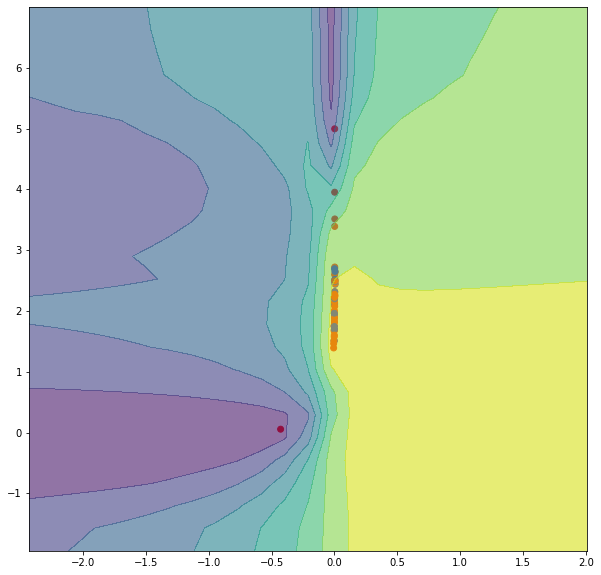

In [ ]:
# PLOTTING
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# Plot the training points
vfunc = np.vectorize(lambda x : np.where(classifier.classes_ == x)[0])
y_train_index = vfunc(y_train)
y_train_index = y_train_index == 0

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train_index, cmap=cm_bright)

classifier.fit(X_train[:, 0:2], y_train_index)

DecisionBoundaryDisplay.from_estimator(
    classifier, X_train[:, 0:2], alpha=0.6, ax=ax, eps=2.0, grid_resolution=25, response_method="predict_proba"
)